# Testing Loiter Attack with One and Multi-Step approach
This notebook looks at detecting GPS spoofing during loiter with the one-step
and multi-step approaches. Ideally the multi-step approach would showcase how
the method can be used to detect spoofing by comparing the GPS Ground Course to
the Optical Flow and Magnetometer Ground Course.

The data files can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.

## Multi-Step, 1m/s/s, 10m offset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "multistep_loiter_2m.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output, SNS_COUNT=4)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

#Get rid of duplicate rows and convert timestamps to datetime
ofMS = df[df.ofMS.shift() != df.ofMS][["ofMS","frF","frR","brF","brR", "rf", "m00", "m10"]].reset_index()
ofMS['ofMS'] = pd.to_datetime(ofMS['ofMS'], unit='ms')
magUS = df[df.magUS.shift() != df.magUS][["magUS","magx","magy","magz"]].reset_index()
magUS['magUS'] = pd.to_datetime(magUS['magUS'], unit='us')
cUS = df[df.cUS.shift() != df.cUS][["cUS","gyrx","gyry","gyrz","CAN","CAE","CAD","rCAN","rCAE","rCAD", "CVN", "CVE", "CVD"]].reset_index()
cUS['cUS'] = pd.to_datetime(cUS['cUS'], unit='us')
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","lat","lng","gpAlt", "m00", "m10"]].reset_index()
gpsMS['gpsMS'] = pd.to_datetime(gpsMS['gpsMS'], unit='ms')
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf","m22"]].reset_index(drop=True)
rfMS['rfMS'] = pd.to_datetime(rfMS['rfMS'], unit='ms')

attack_start = pd.to_datetime(277009434, unit='us')
attack_end = pd.to_datetime(286421624, unit='us')
benign_dist = 3.703

## Ground Course

In [2]:
from confirmation.process import geodetic2ned
from confirmation.process import body_to_earth2D, low_pass_filter
from confirmation.process import signal_match_and_cumsum, change_in_signal
import matplotlib.pyplot as plt
from matplotlib import dates
from scipy.integrate import trapezoid

#GPS Ground Course
gps = geodetic2ned(gpsMS.lat, gpsMS.lng, gpsMS.gpAlt)
gps_north = gps.North.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds())
gps_east = gps.East.diff().fillna(0)/(gpsMS.gpsMS.diff().dt.total_seconds())
gps_down = gps.Down.diff().fillna(0)/100/(gpsMS.gpsMS.diff().dt.total_seconds())

gps_east = pd.Series(gps_east)
gps_north = pd.Series(gps_north)

#Magnetometer Pitch and Heading
from confirmation.process import mag_to_pitch, mag_to_heading
mag_pitch = pd.DataFrame(data={'magUS':magUS.magUS, 'pitch':mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)})
mag_heading = mag_to_heading(magUS.magz, magUS.magy, magUS.magx)

In [3]:
from math import degrees, atan2
from confirmation.process import trap_integrate, signal_match_and_cumsum

#GPS derived ground course
gps_gc = []
for reading in range(len(gps_north)):
    gps_gc.append(degrees(atan2(gps_east[reading], gps_north[reading])) % 360)
gps_gc = pd.Series(gps_gc, name="GPS Ground Course")

#Magnetometer Pitch and Heading
from confirmation.process import mag_to_pitch, mag_to_heading
mag_pitch = mag_to_pitch(magUS.magz, magUS.magy, magUS.magx)
mag_heading = mag_to_heading(magUS.magz, magUS.magy, magUS.magx)

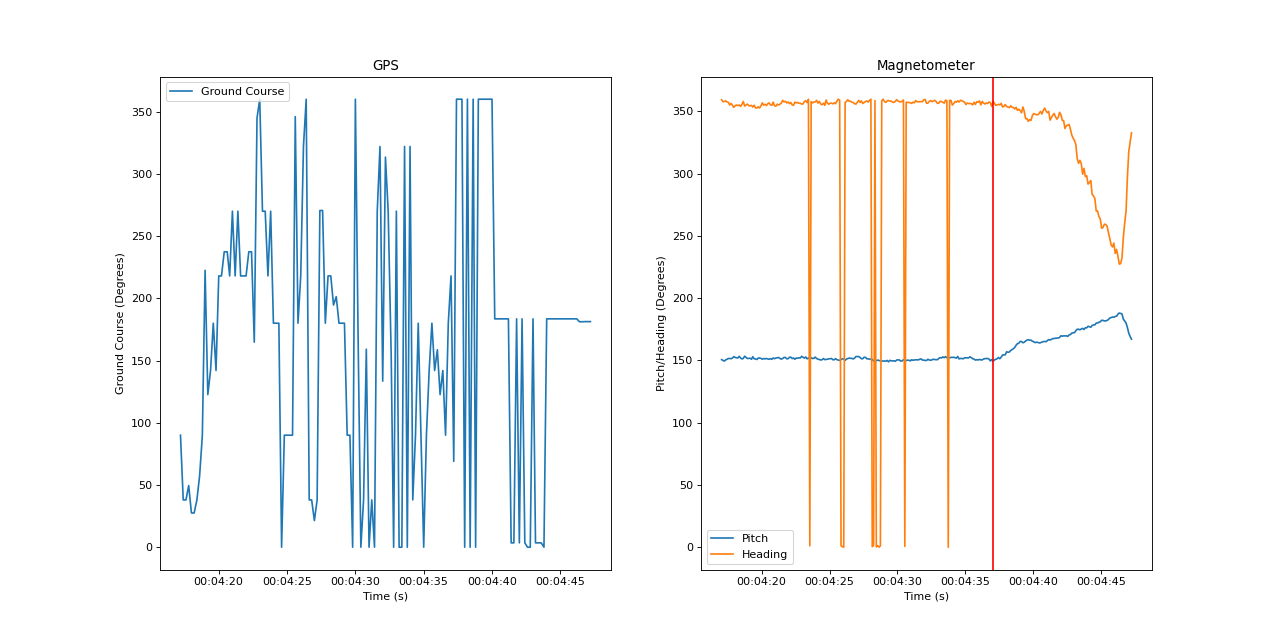

In [4]:
plt.figure(1, figsize=(16, 8), dpi=80)
ax = plt.subplot(1, 2, 1)
plt1 = plt.plot(gpsMS.gpsMS, gps_gc, label="Ground Course")
plt.title("GPS")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Ground Course (Degrees)")

ax = plt.subplot(1, 2, 2)
plt.title("Magnetometer")
plt2 = plt.plot(magUS.magUS, mag_pitch, label="Pitch")
plt3 = plt.plot(magUS.magUS, mag_heading, label="Heading")
plt.xlabel("Time (s)")
plt.ylabel("Pitch/Heading (Degrees)")
plt.axvline(attack_start, color='r')
plt.legend()
plt.show()

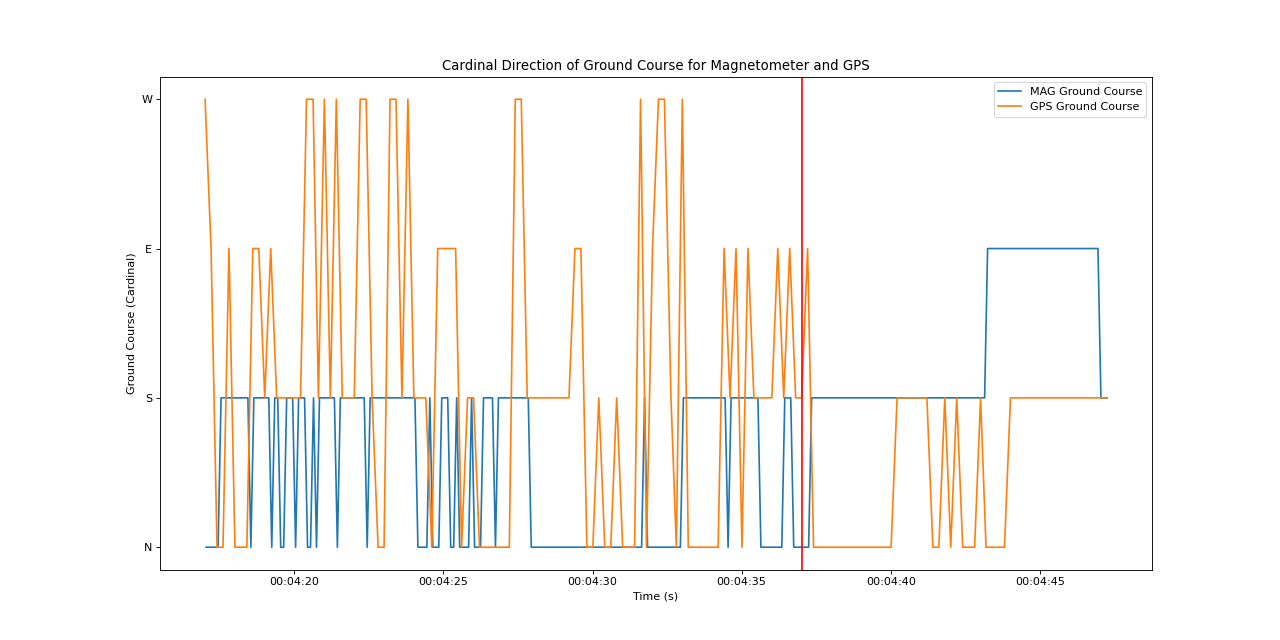

In [5]:
from confirmation.process import head_to_card
mag_card = head_to_card(mag_heading)

#assuming hovering and oscillating between being level
mag_pitch = mag_pitch - mag_pitch[magUS.magUS < attack_start].mean()
mag_gc = []

for index in range(len(mag_heading)):
    card = mag_card[index]
    if mag_pitch[index] <= 0:
        mag_gc.append(card)
    else:
        if card == "N":
            mag_gc.append("S")
        elif card == "E":
            mag_gc.append("W")
        elif card == "S":
            mag_gc.append("N")
        else:
            mag_gc.append("E")
            
mag_gc = pd.Series(mag_gc, name="MAG Ground Course")

plt.figure(2, figsize=(16, 8), dpi=80)
plt.plot(magUS.magUS, mag_gc, label="MAG Ground Course")
plt.plot(gpsMS.gpsMS, head_to_card(gps_gc), label="GPS Ground Course")
plt.legend()
plt.axvline(attack_start, color='r')
plt.title("Cardinal Direction of Ground Course for Magnetometer and GPS")
plt.xlabel("Time (s)")
plt.ylabel("Ground Course (Cardinal)")
plt.show()